# Using the KNMI precipitation data
This notebook describes how to generate a buienradar-like app from the 
Royal Netherlands Meteorological Institute (KNMI) API radar data

In [8]:
import datetime
import io
import json
import math
import os
import urllib

from dotenv import load_dotenv
import h5py
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

## Data
- Title: Precipitation - radar 5 minute reflectivity composites over the Netherlands
- Source: https://dataplatform.knmi.nl/dataset/radar-reflectivity-composites-2-0
- Abstract: Gridded files of radar reflectivities at 1500 m over the Netherlands and 
  surrounding area measured by two radars in Herwijnen and Den Helder. 
  Time interval is 5 minutes.

Request a KNMI API key here: https://developer.dataplatform.knmi.nl/apis

In [3]:
# save your api key to a file called '.env' in the current dir or any parent dir, 
# containing a line with contents 'knmi_api_key=XXXXXXXXXX'
load_dotenv()
knmi_api_key = os.getenv('knmi_api_key')

In [4]:
def get_radar_data(key: str, timestamp: str):
    """ Get the radar data image using the KNMI API.
    Script adapted from https://github.com/berthubert/knmi-precipitation-radar-scripts/blob/main/knmi-precip-radar-script.ipynb
    """
    # 
    url = 'https://api.dataplatform.knmi.nl/open-data/v1/datasets/'\
        + 'radar_reflectivity_composites/versions/2.0/files/RAD_NL25_PCP_NA_'\
        + timestamp + '.h5/url'
    headers = {'Authorization': key}

    # Request a temporary download url
    req = urllib.request.Request(url, headers=headers)
    with urllib.request.urlopen(req) as response:
        meta = response.read()
    
    real_url = json.loads(meta)["temporaryDownloadUrl"]
    req = urllib.request.Request(real_url)
    with urllib.request.urlopen(req) as response:
        return response.read()

In [5]:
# get the latest file
# we subtract another 5 minutes since files are often uploaded a bit late
# Note that here, there is a better way to list all available files at:
# https://developer.dataplatform.knmi.nl/example-scripts
now = datetime.datetime.utcnow()
now = now - datetime.timedelta(minutes=5 + now.minute%5)
start = now
files = {}
while True:
    try:
        tstamp = start.strftime("%Y%m%d%H%M")
        print(f"Retrieving {tstamp=}")
        binaryfile = get_radar_data(knmi_api_key, tstamp)
        files[tstamp] = binaryfile
        
        start += datetime.timedelta(minutes=5)
    except urllib.error.HTTPError:
        break

Retrieving tstamp='202311140710'
Retrieving tstamp='202311140715'


## Exploring a single image
H5 is one of the Hierarchical Data Formats (HDF) used to store large amount of data. 
It is a bit annoying to explore, but let us list all its fields.

A useful source for some background on the fields is: 
https://cdn.knmi.nl/knmi/pdf/bibliotheek/knmipubIR/IR2003-05.pdf

In [6]:
def all_h5_keys(obj: h5py.File or h5py.Group) -> tuple:
    """ list all groups and attributes of an h5 file"""
    "Recursively find all keys in an h5py.Group."
    keys = (obj.name,)
    if isinstance(obj, h5py.Group):
        for key, value in obj.items():
            if isinstance(value, h5py.Group):
                keys = keys + all_h5_keys(value)
                
                for attr, v in value.attrs.items():
                    keys = keys + ((f"{value.name}/{attr}", v),)
            else:
                keys = keys + (value.name,)
                for attr, v in value.attrs.items():
                    keys = keys + ((f"{value.name}/{attr}", v),)
    return keys

In [9]:
# read the first file
knmi_h5 = h5py.File(io.BytesIO(files[list(files)[-1]]))
all_h5_keys(knmi_h5)

('/',
 '/geographic',
 '/geographic/map_projection',
 ('/geographic/map_projection/projection_indication', b'Y'),
 ('/geographic/map_projection/projection_name', b'STEREOGRAPHIC'),
 ('/geographic/map_projection/projection_proj4_params',
  b'+proj=stere +lat_0=90 +lon_0=0 +lat_ts=60 +a=6378.14 +b=6356.75 +x_0=0 y_0=0'),
 ('/geographic/geo_column_offset', array([0.], dtype=float32)),
 ('/geographic/geo_dim_pixel', b'KM,KM'),
 ('/geographic/geo_number_columns', array([700])),
 ('/geographic/geo_number_rows', array([765])),
 ('/geographic/geo_par_pixel', b'X,Y'),
 ('/geographic/geo_pixel_def', b'LU'),
 ('/geographic/geo_pixel_size_x', array([1.0000035], dtype=float32)),
 ('/geographic/geo_pixel_size_y', array([-1.0000048], dtype=float32)),
 ('/geographic/geo_product_corners',
  array([ 0.      , 49.362064,  0.      , 55.973602, 10.856453, 55.388973,
          9.0093  , 48.8953  ], dtype=float32)),
 ('/geographic/geo_row_offset', array([3649.982], dtype=float32)),
 '/image1',
 '/image1/cali

# Visualize the radar picture

In [10]:
def get_radar_image(knmi_h5: h5py.File) -> np.array:
    im = np.array(knmi_h5["image1"]["image_data"])
    # values out of range (missing) are filled with 255
    # ('/image1/calibration/calibration_out_of_image', array([255])),
    mask_values = knmi_h5["image1"]["calibration"].attrs['calibration_out_of_image']
    radar_im = np.array(knmi_h5["image1"]["image_data"])

    radar_im = np.ma.masked_where(radar_im < 2, radar_im)
    for v in mask_values:
        radar_im = np.ma.masked_where(radar_im == v, radar_im)
        
    return radar_im

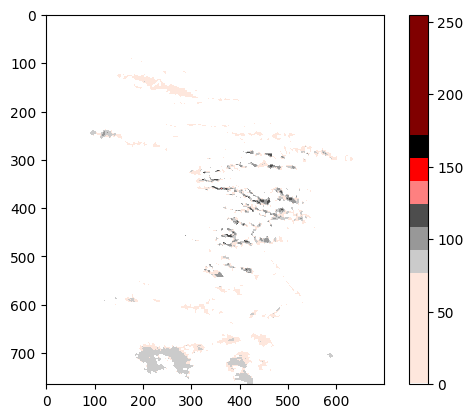

In [11]:
# build the KNMI suggested palette
cmap = np.array(knmi_h5["visualisation1"]["color_palette"])
knmimap = ListedColormap(cmap/256.0)
radar_im = get_radar_image(knmi_h5)

# Show the thing
plt.figure()
plt.imshow(radar_im, cmap=knmimap, vmin=0, vmax=255)
plt.colorbar()
plt.show()

# Rain calibration
Source: https://cdn.knmi.nl/knmi/pdf/bibliotheek/knmipubTR/TR293.pdf

Radar data is in unit dBZ, while we want precipitation in mm/h. To do so, 
we have to first translate the pixel value [0, 255] to dBZ, and then to mm/h.
For the first step, we use the calibration that is in the h5 under 
`/image1/calibration/calibration_formulas`: $0.5\mbox{PV}-32$

The h5 description confirms this, although its 0.5 off.
$\mbox{dBZ} = (\mbox{pv} - 63)/2$,

Then, we use the calibration $\mbox{dBZ} = 16 \log(R) + 23$, 
with base-10 log, and $R$ is the rainfall in $mm/h$

Combining gives the formula R = 10**((pv-109)/32)

In [12]:
assert knmi_h5['/image1/calibration'].attrs['calibration_formulas'] == b'GEO = 0.500000 * PV + -32.000000'

In [13]:
def dbz2mmh(x: int) -> float:
    """ Translates dBZ unit to mm/h precipitation """
    return 10 ** ((x-109.0)/32.0)

In [14]:
def get_rain_image(knmi_h5: h5py.File) -> np.array:
    """ Get the rain image from the h5 """
    radar_im = get_radar_image(knmi_h5)
    rain_im = dbz2mmh(radar_im)
    return rain_im

# Visualize precipitation image: [TODO: fix color scheme]!

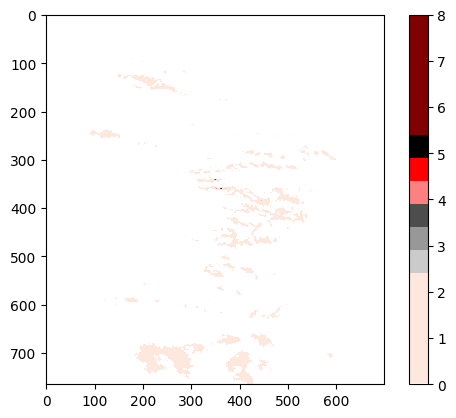

In [15]:
rain_im = get_rain_image(knmi_h5)
knmimap = ListedColormap(np.array(knmi_h5["visualisation1"]["color_palette"])/256.0)

# Show the thing
plt.figure()
plt.imshow(rain_im, cmap=knmimap, vmin=0, vmax=8)
plt.colorbar()
plt.show()

# Track lon/lat pts on the figure

In [16]:
def degsin(x): return math.sin(math.radians(x))
def degcos(x): return math.cos(math.radians(x))
def degtan(x): return math.tan(math.radians(x))

def f(B, e): 
    return ((((1-e)*(1+e*degsin(B)))/((1+e)*(1-e*degsin(B))))**(e/2))/math.sqrt(1-e*e)

def r(B, R, e): 
    return 2*R*f(B, e)*degtan(45-B/2)

def s(B, e): 
    return 2*f(B, e)*math.sqrt(1-(e*degsin(B))**2)/(1+degsin(B))

def pixelcoordinates(knmi_h5, lat, lon):
    B = lat
    L = lon
    
    proj4_str = str(knmi_h5['/geographic/map_projection'].attrs['projection_proj4_params'], encoding='utf-8')
    proj4_params = dict(item.lstrip('+').split('=') for item in proj4_str.split())
    R = float(proj4_params['a'])
    Rp = float(proj4_params['b'])
    B0 = float(proj4_params['lat_ts'])
    L0 = float(proj4_params['lon_0'])
    
    # See https://cdn.knmi.nl/knmi/pdf/bibliotheek/knmipubTR/TR293.pdf, page 73
    # Eccentricity e, is about 0.081...
    e = math.sqrt(1-(Rp/R)**2)
    
    px = knmi_h5['geographic'].attrs['geo_pixel_size_x'][0]
    py = -knmi_h5['geographic'].attrs['geo_pixel_size_y'][0]

    i0 = knmi_h5['geographic'].attrs['geo_column_offset'][0]
    j0 = knmi_h5['geographic'].attrs['geo_row_offset'][0]
    
    x = r(B, R, e) / (px*s(B0, e)) * degsin(L-L0) - i0
    y = r(B, R, e) / (py*s(B0, e)) * degcos(L-L0) - j0
    
    return x, y

0.0 765.0
0.0 -0.0
700.0 -0.0
700.0 765.0


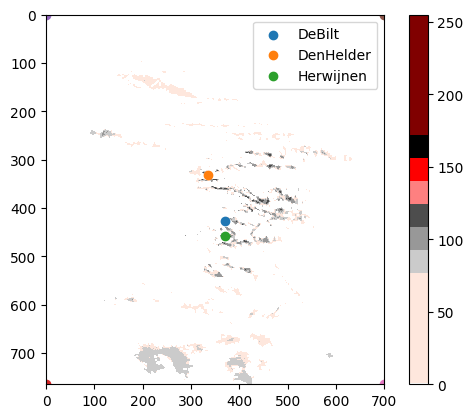

In [17]:
# Show the thing
plt.figure()
knmimap = ListedColormap(np.array(knmi_h5["visualisation1"]["color_palette"])/256.0)
plt.imshow(radar_im, cmap=knmimap, vmin=0, vmax=255)
plt.colorbar()

plt.xlim(0, knmi_h5['geographic'].attrs['geo_number_columns'])
plt.ylim(knmi_h5['geographic'].attrs['geo_number_rows'], 0)


# Plot radar locations:
for i in range(knmi_h5['overview'].attrs['number_radar_groups'][-1]):
    x, y = pixelcoordinates(
        knmi_h5, 
        lat=knmi_h5[f'radar{i+1}'].attrs['radar_location'][1], 
        lon=knmi_h5[f'radar{i+1}'].attrs['radar_location'][0]
    )
    plt.scatter(x, y, label=str(knmi_h5[f'radar{i+1}'].attrs['radar_name'], encoding='utf-8'))

# Sanity check
# corners should be equal to the image size [0, 700], [0, 765]
corners = knmi_h5['geographic'].attrs['geo_product_corners']

for i in range(len(corners)//2):
    x, y = pixelcoordinates(knmi_h5, lat=corners[i*2+1], lon=corners[i*2])
    plt.scatter(x, y)
    print(round(x, 2), round(y, 2))

plt.legend()
plt.show()

# Alternative: Get coordinates using pyproj
Install pyproj in your repo: !pip install pyproj

In [19]:
from pyproj import Transformer

projstr = '+proj=longlat +x_0=0 y_0=0'
knmi_proj4 = str(knmi_h5['geographic/map_projection'].attrs['projection_proj4_params'], encoding='utf-8')
transformer = Transformer.from_crs(projstr, knmi_proj4)

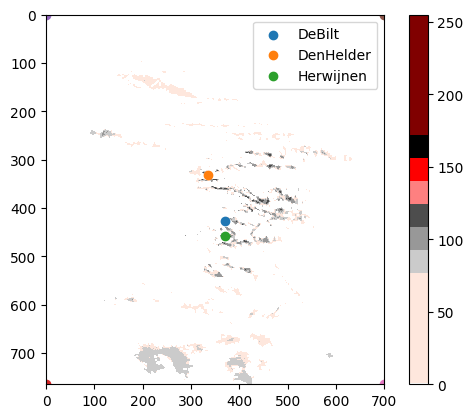

In [20]:
# Show the thing
# build the KNMI suggested palette
knmimap = ListedColormap(np.array(knmi_h5["visualisation1"]["color_palette"])/256.0)
radar_im = get_radar_image(knmi_h5)
plt.figure()
plt.imshow(radar_im, cmap=knmimap, vmin=0, vmax=255)
plt.colorbar()

plt.xlim(0, knmi_h5['geographic'].attrs['geo_number_columns'])
plt.ylim(knmi_h5['geographic'].attrs['geo_number_rows'], 0)

xoffset = knmi_h5['geographic'].attrs['geo_column_offset'][0]
yoffset = knmi_h5['geographic'].attrs['geo_row_offset'][0]

# Plot radar locations:
for i in range(knmi_h5['overview'].attrs['number_radar_groups'][-1]):
    x, y = transformer.transform(
        knmi_h5[f'radar{i+1}'].attrs['radar_location'][0],
        knmi_h5[f'radar{i+1}'].attrs['radar_location'][1], 
    )
    plt.scatter(x + xoffset, -(y + yoffset), label=str(knmi_h5[f'radar{i+1}'].attrs['radar_name'], encoding='utf-8'))

# Sanity check
# corners should be equal to the image size [0, 700], [0, 765]
corners = knmi_h5['geographic'].attrs['geo_product_corners']

for i in range(len(corners)//2):
    x, y = transformer.transform(corners[i*2], corners[i*2 + 1])
    plt.scatter(x + xoffset, -(y + yoffset))

plt.legend()
plt.show()